<a href="https://colab.research.google.com/github/String-ru/AIFFEL_quest_cr/blob/main/MainQuest/Quest03/%EC%8B%9C%ED%96%89%EC%B0%A9%EC%98%A4_MainQuest03_0217_Lung_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#폐암 진단기 개선하기

0217 류지호

#개요

첫째, data를 가져오고 CNN 모델링을 진행한다.

둘째, data imbalance 문제를 해결하고, model을 훈련하고 결과를 살펴볼 것이다.

셋째, 모델의 성능을 높이기 위해 batch size와 epoch수에 변화를 주거나,

augmentation 기법을 통해 원본 data에 대한 전처리 및 배치 구성을 진행한 뒤 결과를 비교할 것이다.

마지막으로, ResNet의 가장 작은 버전인 ResNet-18를 구현하여 학습시킨다.

#목차

1. Set up

2. data 가져오기

3. data 시각화

4. CNN 모델링

5. data imbalance 처리

6. model 훈련

7. 결과 확인

8. Batch size, Epoch 변경해보기 (Step1)

9. data 준비하기 (Step2)

10. data 시각화 (Step3)

11. ResNet-18 구현 (Step4)

12. 데이터 imbalance 처리 (Step5)

13. 모델 훈련 (Step6)

14. 결과 확인과 시각화 (Step7)

15. summary

16. 회고

#1. Set up

필요한 패키지 목록

In [ ]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

변수 생성

In [ ]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel

#2. data 가져오기

In [ ]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

train 안에는 5216개, test 안에는 624개, val 안에는 16개

val 개수가 너무 없기 때문에 train에서 val에 쓰일 data 더 가져오기

train과 val에 있는 data 모으고, train : val를 80:20으로 분할

In [ ]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

In [ ]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072

Pneumonia images count in training set: 3113

정상image보다 폐렴image가 3배 더 많이 있음 -> imbalance 추후 조정 가능

In [ ]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

In [ ]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [ ]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [ ]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)

Label:  False

In [ ]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

#3. data 시각화

In [ ]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

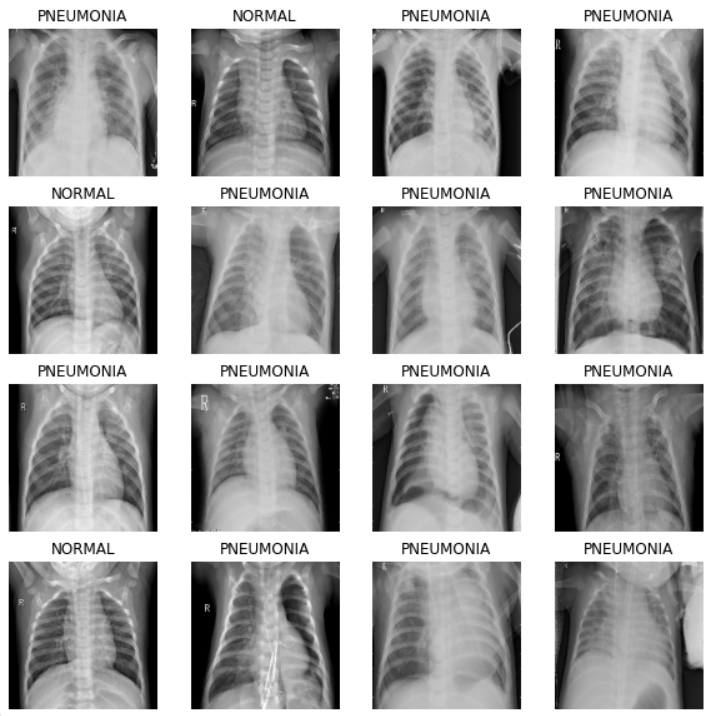

#4. CNN 모델링

Convolution Block 만들기

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block

Dense Block 만들기

In [ ]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

Batch Normalization과 Dropout 동시에 활용하는 모델

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

#5. Data imbalance 처리

In [ ]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95

Weight for PNEUMONIA: 0.67

#6. model 훈련

In [ ]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 100s 202ms/step - loss: 0.4012 - accuracy: 0.7936 - precision: 0.9535 - recall: 0.7595 - val_loss: 0.6712 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000

Epoch 2/10
261/261 [==============================] - 52s 199ms/step - loss: 0.2414 - accuracy: 0.9040 - precision: 0.9721 - recall: 0.8967 - val_loss: 1.1222 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000

Epoch 3/10
261/261 [==============================] - 52s 202ms/step - loss: 0.1829 - accuracy: 0.9334 - precision: 0.9796 - recall: 0.9298 - val_loss: 0.3461 - val_accuracy: 0.8317 - val_precision: 0.8138 - val_recall: 1.0000

Epoch 4/10
261/261 [==============================] - 53s 204ms/step - loss: 0.1734 - accuracy: 0.9334 - precision: 0.9787 - recall: 0.9308 - val_loss: 0.0785 - val_accuracy: 0.9760 - val_precision: 0.9768 - val_recall: 0.9908

Epoch 5/10
261/261 [==============================] - 54s 206ms/step - loss: 0.1677 - accuracy: 0.9337 - precision: 0.9800 - recall: 0.9299 - val_loss: 0.0980 - val_accuracy: 0.9663 - val_precision: 0.9644 - val_recall: 0.9908

Epoch 6/10
261/261 [==============================] - 57s 217ms/step - loss: 0.1465 - accuracy: 0.9464 - precision: 0.9862 - recall: 0.9410 - val_loss: 0.2319 - val_accuracy: 0.9173 - val_precision: 0.9018 - val_recall: 0.9961

Epoch 7/10
261/261 [==============================] - 49s 189ms/step - loss: 0.1566 - accuracy: 0.9420 - precision: 0.9838 - recall: 0.9375 - val_loss: 1.0690 - val_accuracy: 0.6596 - val_precision: 1.0000 - val_recall: 0.5366

Epoch 8/10
261/261 [==============================] - 49s 187ms/step - loss: 0.1264 - accuracy: 0.9509 - precision: 0.9876 - recall: 0.9460 - val_loss: 0.0646 - val_accuracy: 0.9750 - val_precision: 0.9792 - val_recall: 0.9869

Epoch 9/10
261/261 [==============================] - 49s 187ms/step - loss: 0.1303 - accuracy: 0.9516 - precision: 0.9872 - recall: 0.9470 - val_loss: 0.0953 - val_accuracy: 0.9692 - val_precision: 0.9657 - val_recall: 0.9935

Epoch 10/10
261/261 [==============================] - 49s 187ms/step - loss: 0.1299 - accuracy: 0.9574 - precision: 0.9861 - recall: 0.9564 - val_loss: 0.0811 - val_accuracy: 0.9702 - val_precision: 0.9841 - val_recall: 0.9751

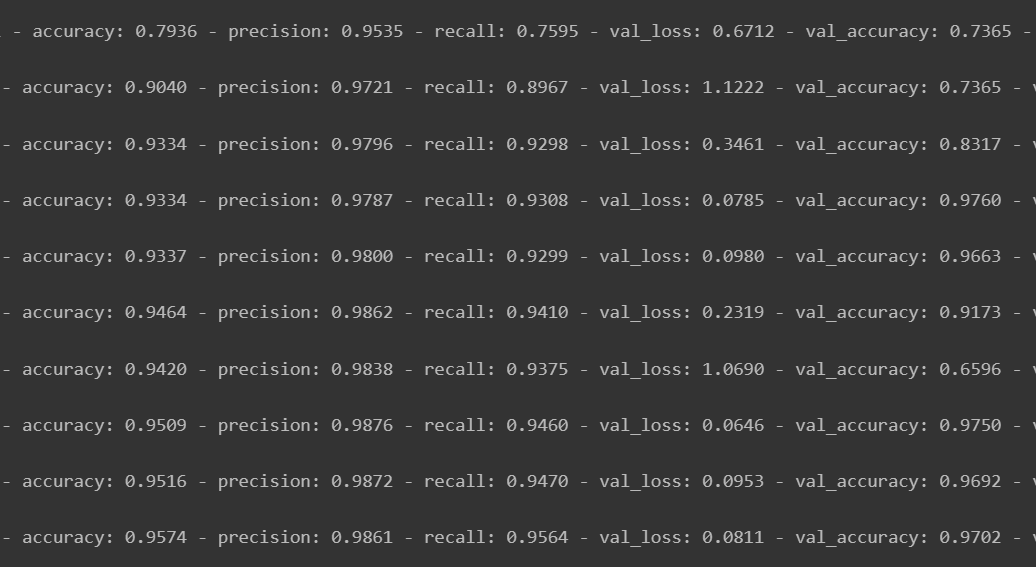

#7. 결과 확인

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

Epochs마다 나타난 모델의 precision, recall, accuracy, loss

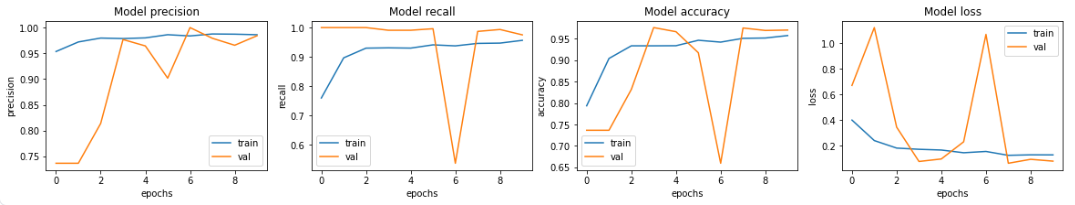

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 118ms/step -

loss: 0.7522 - accuracy: 0.8077 - precision: 0.7733 - recall: 0.9795

Loss: 0.752238392829895

Accuracy: 0.807692289352417

Precision: 0.7732793688774109

Recall: 0.9794871807098389

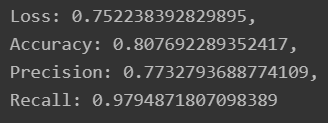

#8. Batch size, Epoch 변경해보기 (Step1)

In [ ]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 30
EPOCHS = 15

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()

# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정

    # sample_weight 추가
    sample_weight = tf.cast(label, tf.float32) * tf.cast((weight_for_1 if label else weight_for_0), tf.float32)

    return img, label, sample_weight

train_ds = train_ds.repeat()
train_ds = train_list_ds.map(process_path).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_list_ds.map(process_path).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    )

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

# 모델 훈련
# 훈련 시 steps_per_epoch 설정
history = model.fit(train_ds, epochs=15, validation_data=val_ds, steps_per_epoch=len(train_ds) // BATCH_SIZE)

# 훈련 과정 시각화
# 훈련 과정 시각화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    if 'val_' + met in history.history:
        ax[i].plot(history.history['val_' + met])  # 검증 메트릭 존재시 plot
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# test_ds 정의
test_filenames = tf.io.gfile.glob(TEST_PATH)
test_list_ds = tf.data.Dataset.from_tensor_slices(test_filenames)

# 테스트 데이터셋에 대해 이미지 로딩 및 처리
test_ds = test_list_ds.map(process_path).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# 모델 평가
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

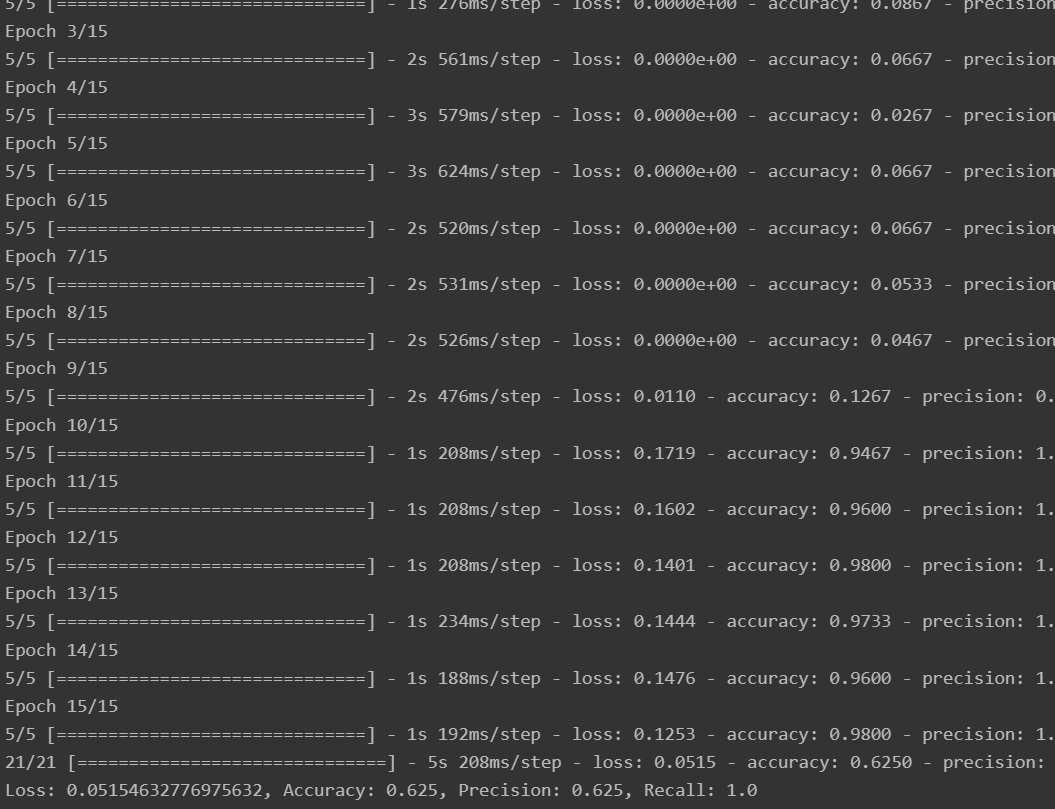

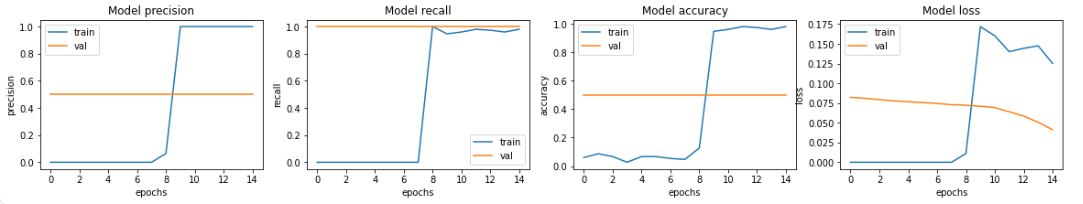

BATCH_SIZE = 30로 변경 (16->30)

EPOCHS = 15로 변경 (10 -> 15)

=> Accuracy: 0.625 로 하락

Epoch 1/15
173/173 [==============================] - 39s 212ms/step - loss: 0.1749 - accuracy: 0.7019 - precision: 0.8128 - recall: 0.7771

Epoch 2/15
  1/173 [..............................] - ETA: 13s - loss: 0.1225 - accuracy: 0.9231 - precision: 1.0000 - recall: 0.9231WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 2595 batches). You may need to use the repeat() function when building your dataset.
173/173 [==============================] - 0s 296us/step - loss: 0.1225 - accuracy: 0.9231 - precision: 1.0000 - recall: 0.9231

Epoch 1/15
5/5 [==============================] - 5s 899ms/step - loss: 0.0000e+00 - accuracy: 0.0600 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0823 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000

Epoch 2/15
5/5 [==============================] - 1s 276ms/step - loss: 0.0000e+00 - accuracy: 0.0867 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0810 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000

Epoch 3/15
5/5 [==============================] - 2s 561ms/step - loss: 0.0000e+00 - accuracy: 0.0667 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0793 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000

Epoch 4/15
5/5 [==============================] - 3s 579ms/step - loss: 0.0000e+00 - accuracy: 0.0267 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0778 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 5/15
5/5 [==============================] - 3s 624ms/step - loss: 0.0000e+00 - accuracy: 0.0667 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0767 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000

Epoch 6/15
5/5 [==============================] - 2s 520ms/step - loss: 0.0000e+00 - accuracy: 0.0667 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0756 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000

Epoch 7/15
5/5 [==============================] - 2s 531ms/step - loss: 0.0000e+00 - accuracy: 0.0533 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0746 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000

Epoch 8/15
5/5 [==============================] - 2s 526ms/step - loss: 0.0000e+00 - accuracy: 0.0467 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0729 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000

Epoch 9/15
5/5 [==============================] - 2s 476ms/step - loss: 0.0110 - accuracy: 0.1267 - precision: 0.0643 - recall: 1.0000 - val_loss: 0.0723 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000

Epoch 10/15
5/5 [==============================] - 1s 208ms/step - loss: 0.1719 - accuracy: 0.9467 - precision: 1.0000 - recall: 0.9467 - val_loss: 0.0710 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000

Epoch 11/15
5/5 [==============================] - 1s 208ms/step - loss: 0.1602 - accuracy: 0.9600 - precision: 1.0000 - recall: 0.9600 - val_loss: 0.0693 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000

Epoch 12/15
5/5 [==============================] - 1s 208ms/step - loss: 0.1401 - accuracy: 0.9800 - precision: 1.0000 - recall: 0.9800 - val_loss: 0.0640 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000

Epoch 13/15
5/5 [==============================] - 1s 234ms/step - loss: 0.1444 - accuracy: 0.9733 - precision: 1.0000 - recall: 0.9733 - val_loss: 0.0586 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000

Epoch 14/15
5/5 [==============================] - 1s 188ms/step - loss: 0.1476 - accuracy: 0.9600 - precision: 1.0000 - recall: 0.9600 - val_loss: 0.0507 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000

Epoch 15/15
5/5 [==============================] - 1s 192ms/step - loss: 0.1253 - accuracy: 0.9800 - precision: 1.0000 - recall: 0.9800 - val_loss: 0.0412 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000

21/21 [==============================] - 5s 208ms/step - loss: 0.0515 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000

# Loss: 0.05154632776975632, Accuracy: 0.625, Precision: 0.625, Recall: 1.0

---
#9. data 준비하기 (Step2)

https://docs.google.com/presentation/d/1-jN3SKNE63gfW36FF-GTlOTMnJbeVoMj/edit#slide=id.p5

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

loss, accuracy, precision, recall = model.evaluate(test_ds)

import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [224, 224]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 30
EPOCHS = 15

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()

# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)  # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32)  # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE)  # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path)  # 라벨 검출
    img = tf.io.read_file(file_path)  # 이미지 읽기
    img = decode_img(img)  # 이미지를 알맞은 형식으로 수정
    
    # sample_weight 추가
    sample_weight = tf.cast(label, tf.float32) * tf.cast((weight_for_1 if label else weight_for_0), tf.float32)
    
    return img, label, sample_weight

train_ds = train_ds.repeat()
train_ds = train_list_ds.map(process_path).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_list_ds.map(process_path).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

def preprocess_image(image):
    image = tf.image.resize(image, IMAGE_SIZE)  # 224x224로 리사이즈
    return image

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    )

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

# 모델 훈련
# 훈련 시 steps_per_epoch 설정
history = model.fit(train_ds, epochs=15, validation_data=val_ds, steps_per_epoch=len(train_ds) // BATCH_SIZE)

# 훈련 과정 시각화
# 훈련 과정 시각화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    if 'val_' + met in history.history:
        ax[i].plot(history.history['val_' + met])  # 검증 메트릭 존재시 plot
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# test_ds 정의
test_filenames = tf.io.gfile.glob(TEST_PATH)
test_list_ds = tf.data.Dataset.from_tensor_slices(test_filenames)

# 테스트 데이터셋에 대해 이미지 로딩 및 처리
test_ds = test_list_ds.map(process_path).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# 모델 평가
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

https://chatgpt.com/c/67b285fb-a5a8-8000-a51d-529c4886104c

#10. data 시각화 (Step3)

#11. ResNet-18 구현 (Step4)

#12. 데이터 imbalance 처리 (Step5)

#13. 모델 훈련 (Step6)

#14. 결과 확인과 시각화 (Step7)

#15. summary

#16. 회고

#8번 결과에 대한 회고

<batch size와 epoch수를 바꾸기 전 결과(16, 10)>

loss: 0.7522 - accuracy: 0.8077 - precision: 0.7733 - recall: 0.9795
---
<batch size와 epoch수를 바꾼 후 결과(30, 15)>

Loss: 0.05154632776975632, Accuracy: 0.625, Precision: 0.625, Recall: 1.0
---
---
loss 값 감소 => model이 예측을 더 잘하고 있다

accuracy값 감소 => model이 여전히 잘못된 예측을 하고 있다

특히 recall = 1.0 을 참고하면,

양성 클래스에 대해서는 잘 예측하고 있지만, 음성 클래스에 대한 예측은 덜 정확하다는 판단을 할 수 있다.

#1차 결론:

이 결과에는 여러가지 원인이 있을 수 있지만,

data내 class에 불균형이 있을 경우 이러한 결과가 나타날 수 있다는 것을 확인했다.

#2차 결론:

데이터 증강(Data Augmentation)을 사용하여 훈련 데이터를 늘려주는 방법을 시도해봐야겠다.